Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz

Neural network: Hidden1:800, Hidden2:800
 Training size:60000 * epochs:20 / mini_batch_size:128 = total_mini_batches:9360
 Learning rate:0.0001

Running process: [timeout 300 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv,nounits -lms 100 -f GPU-info.csv]
BEFORE Training
  TRAIN cost/acc:5.5453/0.0881, TEST cost/acc:5.4776/0.0902
After mini batch 468 of 9360
  TRAIN cost/acc:0.2137/0.9386, TEST cost/acc:0.2272/0.9337
After mini batch 936 of 9360
  TRAIN cost/acc:0.1516/0.9558, TEST cost/acc:0.1781/0.9476
After mini batch 1404 of 9360
  TRAIN cost/acc:0.1049/0.9700, TEST cost/acc:0.1305/0.9595
After mini batch 1872 of 9360
  TRAIN cost/acc:0.0825/0.9770, TEST cost/acc:0.1185/0.9632
After mini batch 2340 of 9360
  TRAIN cost/acc:0.0674/0.9812, TEST cost/acc:0.1048/0.9672
After mini batch 2808 of 9360

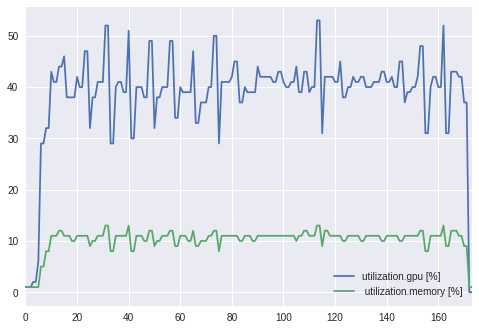


FINISHED
  TRAIN cost/acc:0.0070/0.9990, TEST cost/acc:0.0767/0.9782
TRAINING took 16.321814905153587 seconds.


In [1]:
# Author: Endre Stølsvik, around 2017-07-01

import tensorflow as tf
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py
import tensorflow.examples.tutorials.mnist.input_data as input_data
from timeit import default_timer as timer

# Hyperparameters
hidden1_size = 800
hidden2_size = 800
epochs = 20   # Not explicitly used, as we count mini_batches
mini_batch_size = 128
learning_rate = 0.0001

# Load data, calculate total mini batches:
mnist = input_data.read_data_sets("tmp", one_hot=True, validation_size=0)
mini_batches_per_epoch = int(mnist.train.num_examples / mini_batch_size)
total_mini_batches = epochs * mini_batches_per_epoch

# Define Neural Network

def weight_variable(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
  return tf.Variable(tf.constant(0.1, shape=shape))

def createNeuralNet(inputs, labels):
    layer1_w = weight_variable([28*28, hidden1_size])
    layer1_b = bias_variable([hidden1_size])
    layer1 = tf.matmul(inputs, layer1_w) + layer1_b
    layer1 = tf.nn.elu(layer1)

    layer2_w = weight_variable([hidden1_size, hidden2_size])
    layer2_b = bias_variable([hidden2_size])
    layer2 = tf.matmul(layer1, layer2_w) + layer2_b
    layer2 = tf.nn.elu(layer2)

    # Layer3 == Output layer
    # Notice: Raw values; No activation/transfer function (i.e. Sigmoid, ReLU), nor dropout
    layer3_w = weight_variable([hidden2_size, 10])
    layer3_b = bias_variable([10])
    layer3 = tf.matmul(layer2, layer3_w) + layer3_b

    # Prediction = output
    prediction = layer3


    # Define Training: Loss/Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(cost)

    # Define Test/Evaluate: Accuracy: Fraction right predictions
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return train, cost, accuracy

inputs = labels = train = cost = accuracy = None

# Reset default graph so that we can run again in Jupyter Notebook
tf.reset_default_graph()
# Create TensorFlow Session
s = tf.Session()

def printStats(what):
    train_cost, train_accuracy = s.run([cost, accuracy], 
                                       feed_dict={inputs: mnist.train.images, labels: mnist.train.labels})
    test_cost, test_accuracy = s.run([cost, accuracy], 
                                     feed_dict={inputs: mnist.test.images, labels: mnist.test.labels})
    print("{}\n  TRAIN cost/acc:{:.4f}/{:.4f}, TEST cost/acc:{:.4f}/{:.4f}"\
          .format(what, train_cost, train_accuracy, test_cost, test_accuracy))

print ("\nNeural network: Hidden1:{}, Hidden2:{}"\
       .format(hidden1_size, hidden2_size))
print(" Training size:{} * epochs:{} / mini_batch_size:{} = total_mini_batches:{}"\
       .format(mnist.train.num_examples, epochs, mini_batch_size, total_mini_batches))
print(" Learning rate:{}\n"\
      .format(learning_rate))

# ----------
import subprocess
import shlex
nvidia_smi_max_timeout = 300
cmd = 'timeout {} nvidia-smi'+\
      ' --query-gpu=utilization.gpu,utilization.memory'+\
      ' --format=csv,nounits -lms 100 -f GPU-info.csv'
cmd = cmd.format(nvidia_smi_max_timeout)
print("Running process: [{}]".format(cmd))
nvidia_smi = subprocess.Popen(shlex.split(cmd))
# ----------

# ===== EVERYTHING ABOVE HERE IS IDENTICAL BETWEEN "Plain feed_dict" and "with Queues".


# :: Define inputs, labels, and Neural Network..

# Input values
inputs = tf.placeholder(tf.float32, [None, 28*28])
# Labels - "factual" - about the current input
labels = tf.placeholder(tf.float32, [None, 10])

train, cost, accuracy = createNeuralNet(inputs, labels)

# Initialize TensorFlow variables in Session
s.run(tf.global_variables_initializer())

printStats("BEFORE Training")

### Train Neural Network

# Run training
time_start = timer()
for mini_batch in range(1, total_mini_batches+1):
    batch_inputs, batch_labels = mnist.train.next_batch(mini_batch_size)
    s.run([train, accuracy], feed_dict={inputs: batch_inputs, 
                                           labels: batch_labels})
        
    if (mini_batch % mini_batches_per_epoch == 0):
        printStats("After mini batch {} of {}".format(mini_batch, total_mini_batches))
        
training_time = timer()-time_start

# ----------
import time
time.sleep(0.5)
nvidia_smi.terminate()
time.sleep(0.5)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")
gpu = pd.read_csv("./GPU-info.csv")
gpu.plot()
plt.show()
# ----------

printStats("\nFINISHED")
print("TRAINING took {} seconds.".format(training_time))